#### Modelos de predicción

In [174]:
import pandas as pd
import numpy as np
#Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#Para evitar alertas
import warnings
warnings.filterwarnings('ignore')

In [175]:
df=pd.read_csv("data_preprocessed.csv")
df.iloc[np.random.randint(0,df.shape[0],10),:]

,price,rooms,lift,terrace,square_meters,real_state,neighborhood,square_meters_price
212,1250,2,1,1,62,0,0,20.161290
6987,790,1,1,0,64,2,0,12.343750
6306,870,2,1,1,62,2,1,14.032258
801,850,2,0,1,46,2,1,18.478261
3187,748,0,0,0,29,2,0,25.793103
3264,990,2,1,0,84,2,0,11.785714
3243,1190,2,1,0,68,2,2,17.500000
4839,785,1,1,0,50,2,8,15.700000
6281,2750,3,1,0,200,2,1,13.750000
7839,825,3,0,0,59,0,2,13.983051


In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8180 entries, 0 to 8179
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                8180 non-null   int64  
 1   rooms                8180 non-null   int64  
 2   lift                 8180 non-null   int64  
 3   terrace              8180 non-null   int64  
 4   square_meters        8180 non-null   int64  
 5   real_state           8180 non-null   int64  
 6   neighborhood         8180 non-null   int64  
 7   square_meters_price  8180 non-null   float64
dtypes: float64(1), int64(7)
memory usage: 511.4 KB


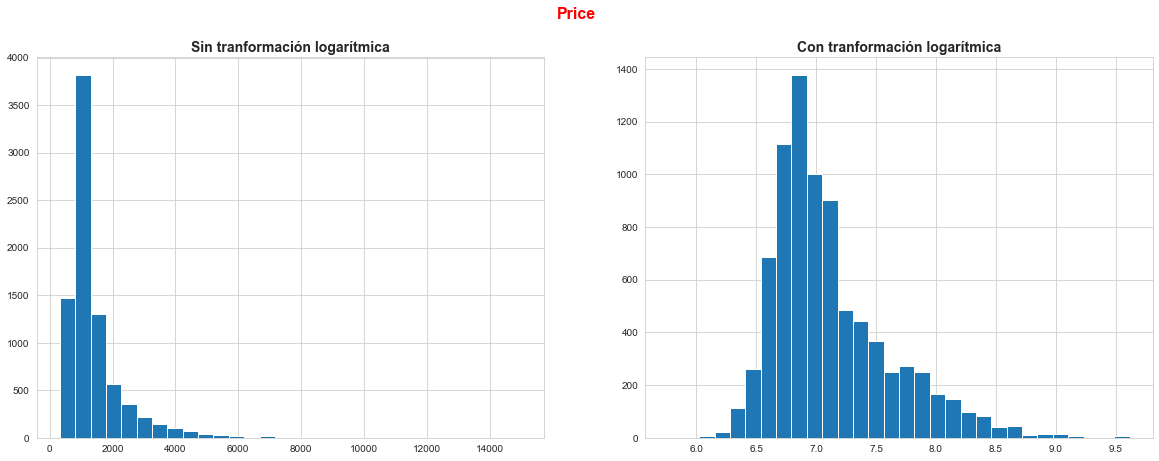

In [177]:
fig,ax=plt.subplots(1,2,figsize=(20,7))
ax[0].hist(df.price,bins=30)
ax[0].set_title('Sin tranformación logarítmica',fontsize=14,fontweight="bold")
ax[1].hist(np.log(df.price),bins=30)
ax[1].set_title('Con tranformación logarítmica', fontsize=14 ,fontweight="bold")
plt.suptitle("Price",fontsize=16,color="red",fontweight="bold")
plt.show()

Haciendo la partición de los datos:

In [178]:
from sklearn.model_selection import train_test_split,cross_validate
train , test = train_test_split(df,test_size=0.2,random_state=141) 
print(f"train:\t{len(train)}\ntest:\t{len(test)}")

train:	6544
test:	1636


Estableciendo la columna objetivo en ambos dataframes:

In [179]:
for dfp in ["train","test"]:
    exec("{0}_x={0}.drop(columns='price')".format(dfp))
    exec("{0}_y={0}.price".format(dfp))

In [180]:
#títulos of gráficos 
curv_val="Curva de validación"
com_target="Comparación de target"
curv_val_trans="Curva de validación con target transformada"
com_target_trans="Comparación de target con previa transformación logarítmica"

In [181]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
main_kfold = KFold(10, shuffle=True, random_state=45)
from sklearn.compose import TransformedTargetRegressor

### Regresión linear simple

In [182]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
lr_pipe = Pipeline([('scale', RobustScaler()),('lr', LinearRegression(n_jobs=-1))])

scoring = {'nmae': 'neg_mean_absolute_error',
           'nmse': 'neg_mean_squared_error',
           'r2': 'r2'}

lr_scores = cross_validate(lr_pipe, train_x, train_y,
                           scoring=scoring, cv=main_kfold,
                           return_train_score=True, return_estimator=True, n_jobs=-1)
lr_pipe.fit(train_x, train_y)

Wall time: 2.2 s


Pipeline(steps=[('scale', RobustScaler()), ('lr', LinearRegression(n_jobs=-1))])

In [183]:
print('Train:', -lr_scores['train_nmae'].mean().round(2))

Train: 163.02


In [184]:
predict_y=lr_pipe.predict(test_x)
error_rl=mean_absolute_error(predict_y,test_y).round(2)
print("Test:",error_rl)

Test: 165.17


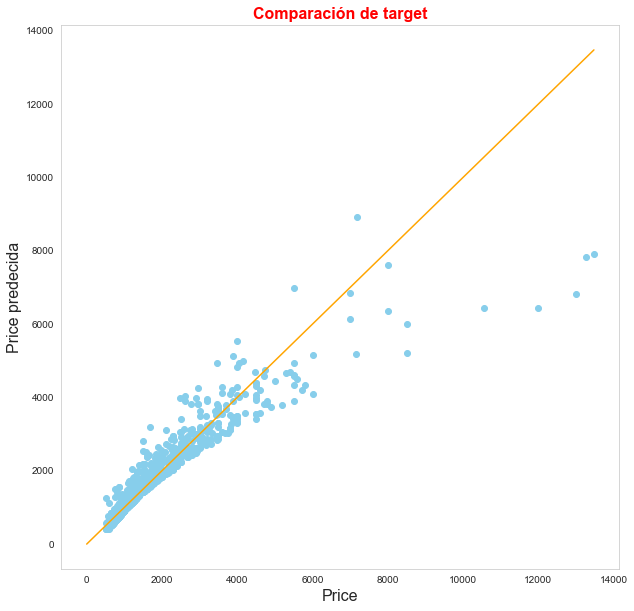

In [185]:
plt.figure(figsize=(10,10))
plt.title(com_target,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="skyblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
#plt.axis('scaled')
plt.xlabel('Price',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

Con tranformación logarítmica:

In [186]:
%%time
lr_trans = TransformedTargetRegressor(lr_pipe,func=np.log,inverse_func=np.exp)
lr_trans_scores = cross_validate(lr_trans, train_x, train_y,
                                 scoring=scoring, cv=main_kfold,
                                 return_train_score=True, return_estimator=True, n_jobs=-1)
#Ajuste del modelo 
lr_trans.fit(train_x, train_y)

Wall time: 980 ms


TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('scale', RobustScaler()),
                                                     ('lr',
                                                      LinearRegression(n_jobs=-1))]))

In [187]:
print('Train:', -lr_trans_scores['train_nmae'].mean().round(2))

Train: 298.09


In [188]:
predict_y=lr_trans.predict(test_x)
predict_y[predict_y==np.inf]=predict_y[predict_y!=np.inf].max()
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 256.03


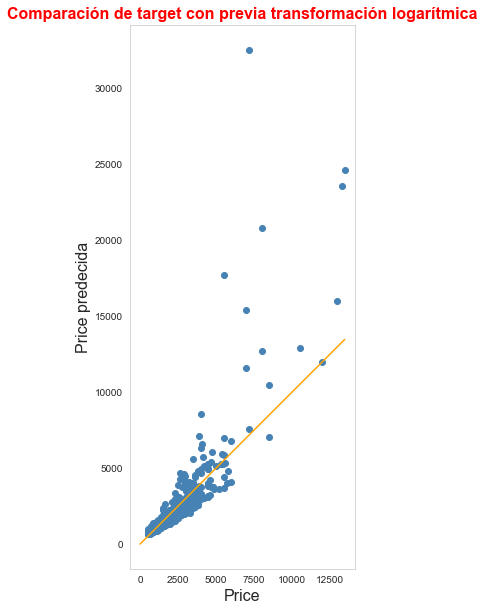

In [189]:
plt.figure(figsize=(10,10))
plt.title(com_target_trans,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Price',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

### Lasso

In [190]:
%%time
from sklearn.linear_model import Lasso
clf = Lasso()
lr_pipe = Pipeline([('scale', RobustScaler()),('lr', clf)])

scoring = {'nmae': 'neg_mean_absolute_error',
           'nmse': 'neg_mean_squared_error',
           'r2': 'r2'}

lr_scores = cross_validate(lr_pipe, train_x, train_y,
                           scoring=scoring, cv=main_kfold,
                           return_train_score=True, return_estimator=True, n_jobs=-1)
lr_pipe.fit(train_x, train_y)

Wall time: 135 ms


Pipeline(steps=[('scale', RobustScaler()), ('lr', Lasso())])

In [191]:
print('Train:', -lr_scores['train_nmae'].mean().round(2))

Train: 162.57


In [192]:
predict_y=lr_pipe.predict(test_x)
error_lasso=mean_absolute_error(predict_y,test_y).round(2)
print("Test:",error_lasso)

Test: 164.9


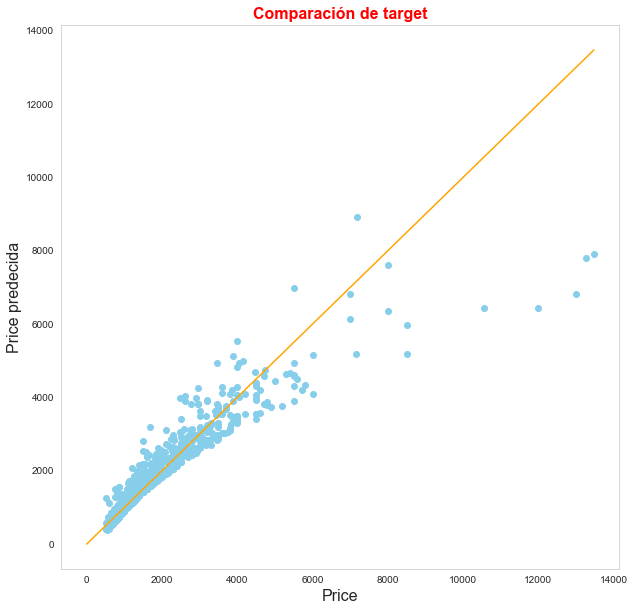

In [193]:
plt.figure(figsize=(10,10))
plt.title(com_target,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="skyblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
#plt.axis('scaled')
plt.xlabel('Price',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show() 

Con transformación logarítmica:

In [194]:
%%time
lr_trans = TransformedTargetRegressor(lr_pipe,func=np.log,inverse_func=np.exp)
lr_trans_scores = cross_validate(lr_trans, train_x, train_y,
                                 scoring=scoring, cv=main_kfold,
                                 return_train_score=True, return_estimator=True, n_jobs=-1)
#Ajuste del modelo 
lr_trans.fit(train_x, train_y)

Wall time: 61.2 ms


TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('scale', RobustScaler()),
                                                     ('lr', Lasso())]))

In [195]:
print('Train:', -lr_trans_scores['train_nmae'].mean().round(2))

Train: 575.53


In [196]:
predict_y=lr_trans.predict(test_x)
predict_y[predict_y==np.inf]=predict_y[predict_y!=np.inf].max()
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 612.61


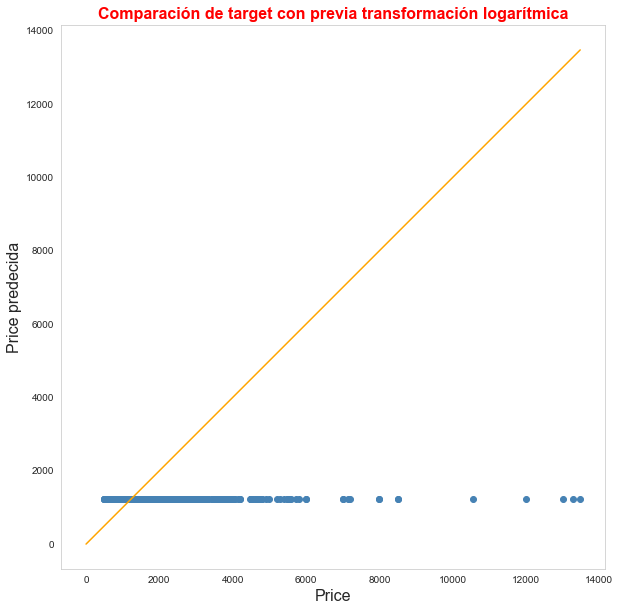

In [197]:
plt.figure(figsize=(10,10))
plt.title(com_target_trans,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Price',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

### Ridge

In [198]:
%%time
from sklearn.linear_model import Ridge
clf = Ridge()
lr_pipe = Pipeline([('scale', RobustScaler()),('lr', clf)])

scoring = {'nmae': 'neg_mean_absolute_error',
           'nmse': 'neg_mean_squared_error',
           'r2': 'r2'}

lr_scores = cross_validate(lr_pipe, train_x, train_y,
                           scoring=scoring, cv=main_kfold,
                           return_train_score=True, return_estimator=True, n_jobs=-1)
lr_pipe.fit(train_x, train_y)

Wall time: 42.7 ms


Pipeline(steps=[('scale', RobustScaler()), ('lr', Ridge())])

In [199]:
print('Train:', -lr_scores['train_nmae'].mean().round(2))

Train: 163.0


In [200]:
predict_y=lr_pipe.predict(test_x)
error_ridge=mean_absolute_error(predict_y,test_y).round(2)
print("Test:",error_ridge)

Test: 165.15


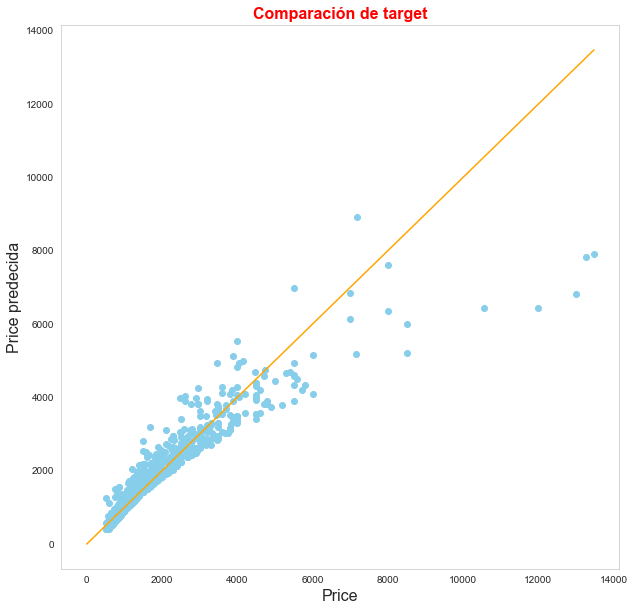

In [201]:
plt.figure(figsize=(10,10))
plt.title(com_target,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="skyblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
#plt.axis('scaled')
plt.xlabel('Price',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show() 

Con tranformación logarítmica:

In [202]:
%%time
lr_trans = TransformedTargetRegressor(lr_pipe,func=np.log,inverse_func=np.exp)
lr_trans_scores = cross_validate(lr_trans, train_x, train_y,
                                 scoring=scoring, cv=main_kfold,
                                 return_train_score=True, return_estimator=True, n_jobs=-1)
#Ajuste del modelo 
lr_trans.fit(train_x, train_y)

Wall time: 55.9 ms


TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('scale', RobustScaler()),
                                                     ('lr', Ridge())]))

In [203]:
print('Train:', -lr_trans_scores['train_nmae'].mean().round(2))

Train: 298.05


In [204]:
predict_y=lr_trans.predict(test_x)
predict_y[predict_y==np.inf]=predict_y[predict_y!=np.inf].max()
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 256.0


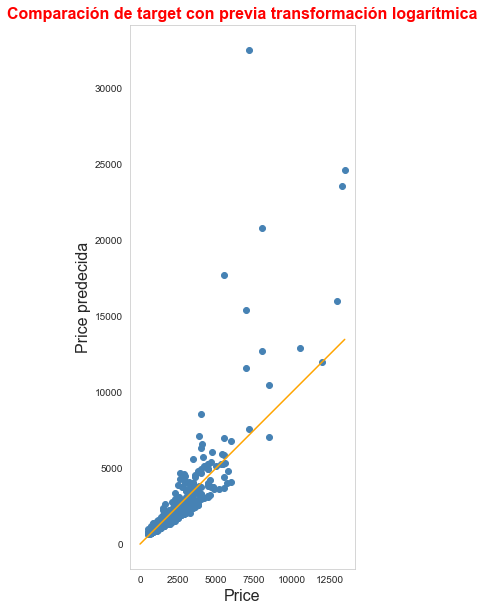

In [205]:
plt.figure(figsize=(10,10))
plt.title(com_target_trans,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Price',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()

### ElasticNet

In [206]:
%%time
from sklearn.linear_model import ElasticNet
clf = ElasticNet()
lr_pipe = Pipeline([('scale', RobustScaler()),('lr', clf)])

scoring = {'nmae': 'neg_mean_absolute_error',
           'nmse': 'neg_mean_squared_error',
           'r2': 'r2'}

lr_scores = cross_validate(lr_pipe, train_x, train_y,
                           scoring=scoring, cv=main_kfold,
                           return_train_score=True, return_estimator=True, n_jobs=-1)
lr_pipe.fit(train_x, train_y)

Wall time: 45.1 ms


Pipeline(steps=[('scale', RobustScaler()), ('lr', ElasticNet())])

In [207]:
print('Train:', -lr_scores['train_nmae'].mean().round(2))

Train: 214.12


In [208]:
predict_y=lr_pipe.predict(test_x)
error_elasticnet=mean_absolute_error(predict_y,test_y).round(2)
print("Test:",error_elasticnet)

Test: 223.51


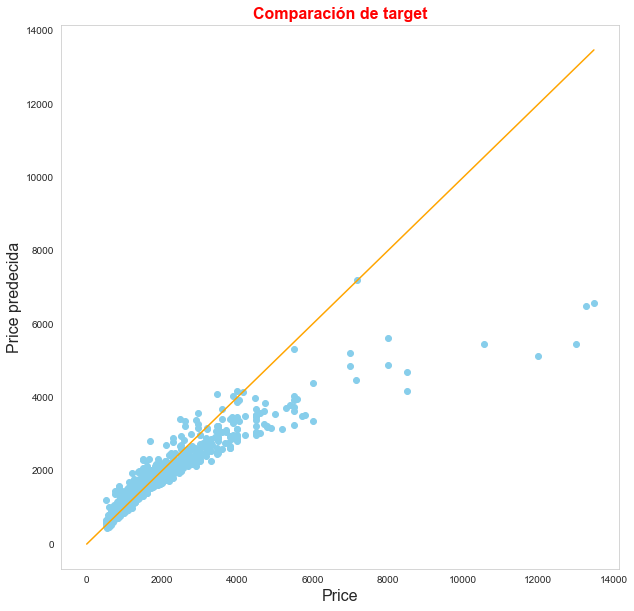

In [209]:
plt.figure(figsize=(10,10))
plt.title(com_target,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="skyblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
#plt.axis('scaled')
plt.xlabel('Price',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show() 

Con transformación logarítmica

In [210]:
%%time
lr_trans = TransformedTargetRegressor(lr_pipe,func=np.log,inverse_func=np.exp)
lr_trans_scores = cross_validate(lr_trans, train_x, train_y,
                                 scoring=scoring, cv=main_kfold,
                                 return_train_score=True, return_estimator=True, n_jobs=-1)
#Ajuste del modelo 
lr_trans.fit(train_x, train_y)

Wall time: 61 ms


TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('scale', RobustScaler()),
                                                     ('lr', ElasticNet())]))

In [211]:
print('Train:', -lr_trans_scores['train_nmae'].mean().round(2))

Train: 575.53


In [212]:
predict_y=lr_trans.predict(test_x)
predict_y[predict_y==np.inf]=predict_y[predict_y!=np.inf].max()
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 612.61


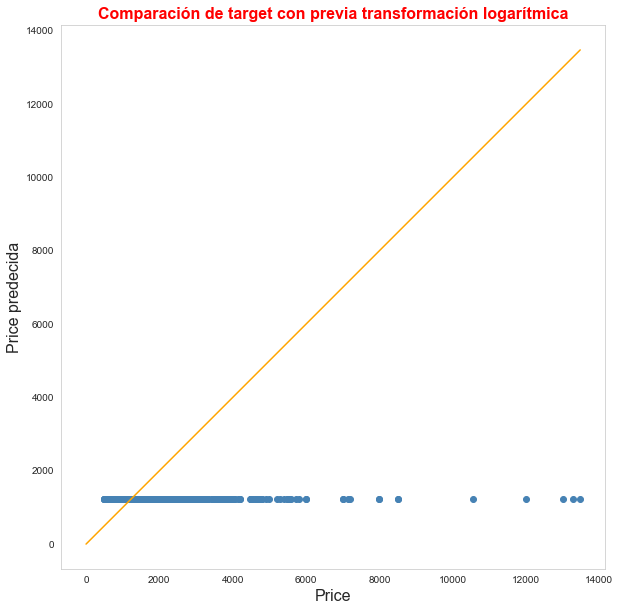

In [213]:
plt.figure(figsize=(10,10))
plt.title(com_target_trans,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Price',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()

### KNN

In [214]:
%%time
n_neighbors= np.arange(3,25,2)
from sklearn.neighbors import KNeighborsRegressor

#Creando un modelo
knn = KNeighborsRegressor(p=1,n_jobs=-1)
#Creando un diccionario de todos los valores que queremos evaluar para n_neighbors
param_grid = {"n_neighbors": n_neighbors}
#Usando gridsearch para evaluar todos los valores para n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
#Ajustando el modelo 
knn_gscv.fit(train_x, train_y)

Wall time: 443 ms


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=KNeighborsRegressor(n_jobs=-1, p=1), n_jobs=-1,
             param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])},
             scoring='neg_mean_absolute_error')

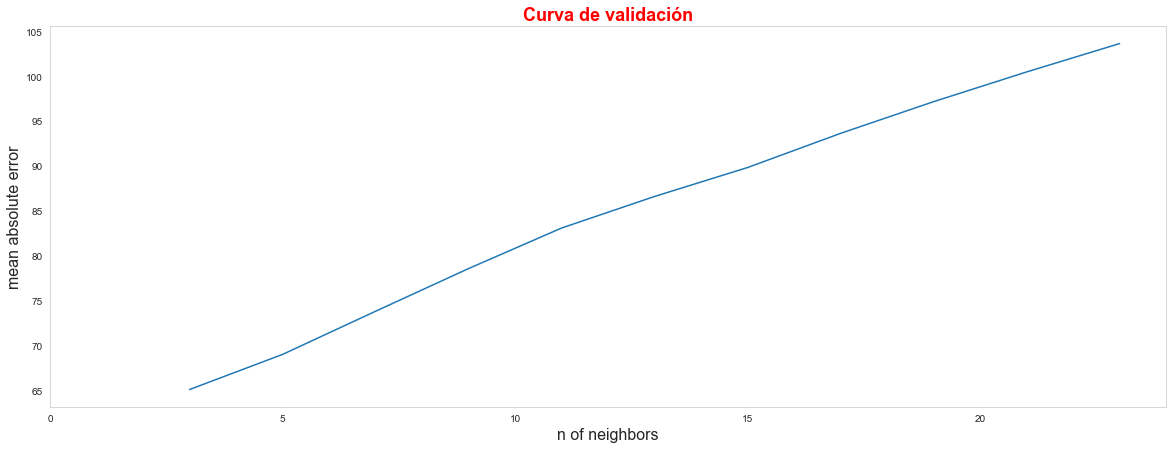

In [215]:
plt.figure(figsize=(20,7))
plt.plot(n_neighbors, -knn_gscv.cv_results_['mean_test_score']) 
plt.title(curv_val,fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of neighbors',fontsize=16)
plt.xticks(np.arange(0,25,step=5))
plt.ylabel('mean absolute error',fontsize=16)
plt.grid(ls='--',lw=0.7) 
plt.show()    

In [216]:
predict_y=knn_gscv.predict(test_x)
error_knn=mean_absolute_error(predict_y,test_y).round(2)
print("Test:",error_knn)

Test: 68.63


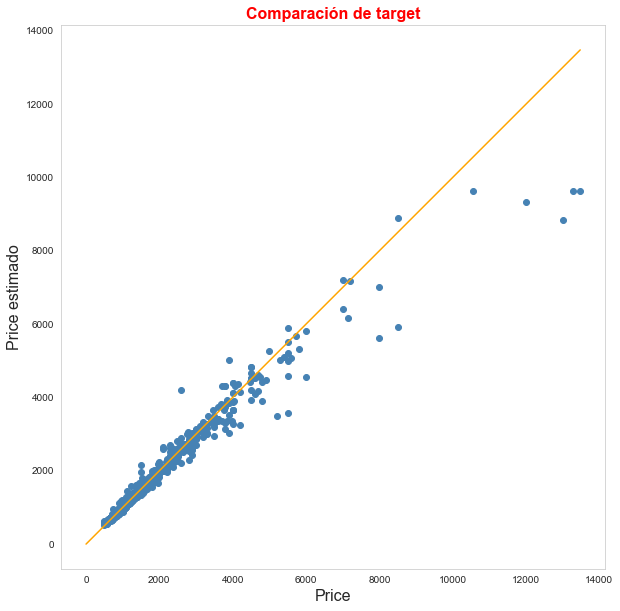

In [217]:
plt.figure(figsize=(10,10))
plt.title(com_target,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Price',fontsize=16)
plt.ylabel('Price estimado',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

Con tranformación logarítmica

In [218]:
%%time
model_pipe = Pipeline([('model', TransformedTargetRegressor(knn,func=np.log,inverse_func=np.exp))])
params_grid_trans={'model__regressor__n_neighbors':n_neighbors}
knn_gscv_trans = GridSearchCV(model_pipe, params_grid_trans, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
knn_gscv_trans.fit(train_x, train_y)

Wall time: 493 ms


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=Pipeline(steps=[('model',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=KNeighborsRegressor(n_jobs=-1,
                                                                                                 p=1)))]),
             n_jobs=-1,
             param_grid={'model__regressor__n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])},
             scoring='neg_mean_absolute_error')

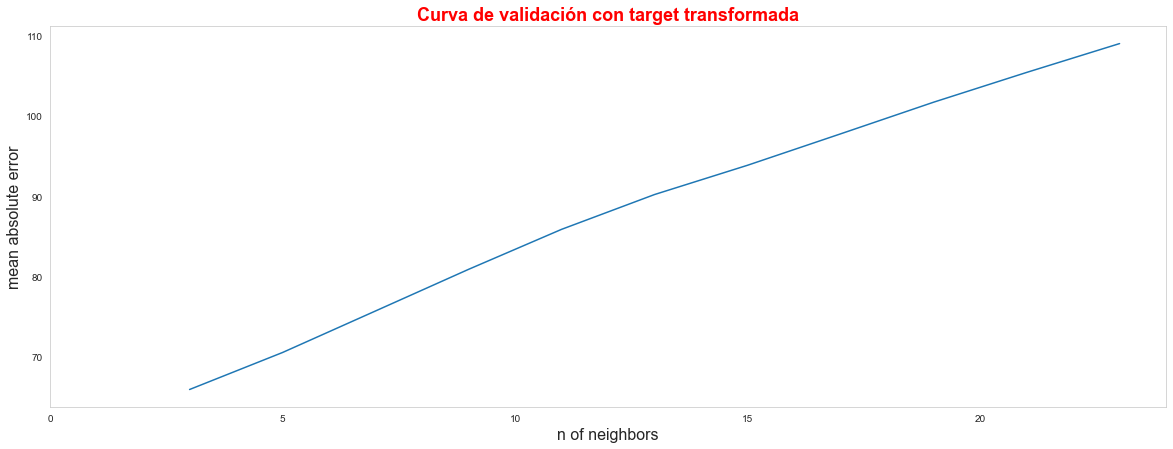

In [219]:
plt.figure(figsize=(20,7))
plt.plot(n_neighbors, -knn_gscv_trans.cv_results_['mean_test_score']) 
plt.title(curv_val_trans,fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of neighbors',fontsize=16)
plt.xticks(np.arange(0,25,step=5))
plt.ylabel('mean absolute error',fontsize=16)
plt.grid(ls='--',lw=0.7) 
plt.show()    

In [220]:
predict_y=knn_gscv_trans.predict(test_x)
print("Test:",mean_absolute_error(test_y,predict_y).round(2))

Test: 70.52


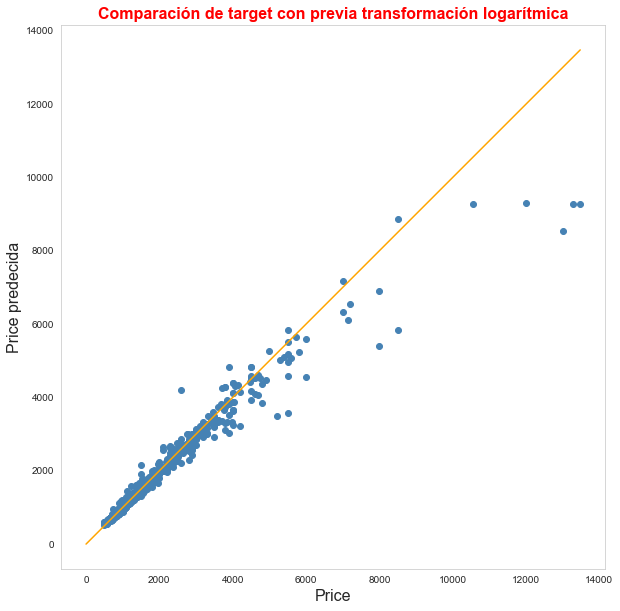

In [221]:
plt.figure(figsize=(10,10))
plt.title(com_target_trans,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Price',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()    

### Random Forest

In [222]:
%%time
N=np.array([15,50,100,250,300,350])
from sklearn.ensemble import RandomForestRegressor 

#Creando un modelo
rf = RandomForestRegressor(n_jobs=-1)
#Creando un diccionario de todos los valores que queremos evaluar para n_neighbors
param_grid = {"n_estimators": N}

#Usando gridsearch para evaluar todos los valores para n_neighbors
rf_gscv = GridSearchCV(rf, param_grid, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
#Ajustando el modelo
rf_gscv.fit(train_x, train_y)

Wall time: 13 s


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'n_estimators': array([ 15,  50, 100, 250, 300, 350])},
             scoring='neg_mean_absolute_error')

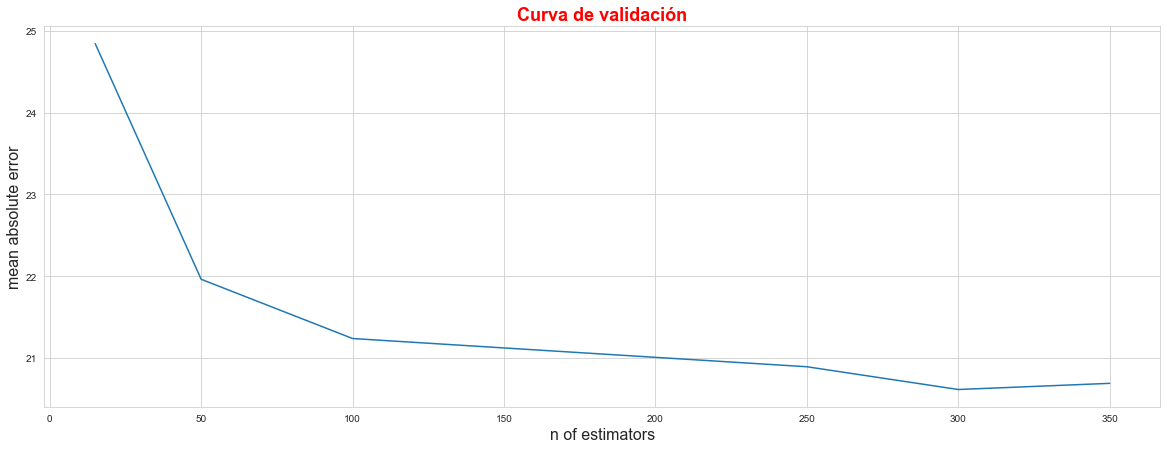

In [223]:
plt.figure(figsize=(20,7))
plt.plot(N, -rf_gscv.cv_results_['mean_test_score']) 
plt.title(curv_val,fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of estimators',fontsize=16)
plt.ylabel('mean absolute error',fontsize=16)
plt.show() 

In [224]:
predict_y=rf_gscv.predict(test_x)
error_rf=mean_absolute_error(predict_y,test_y).round(2)
print("Test:",error_rf)

Test: 22.55


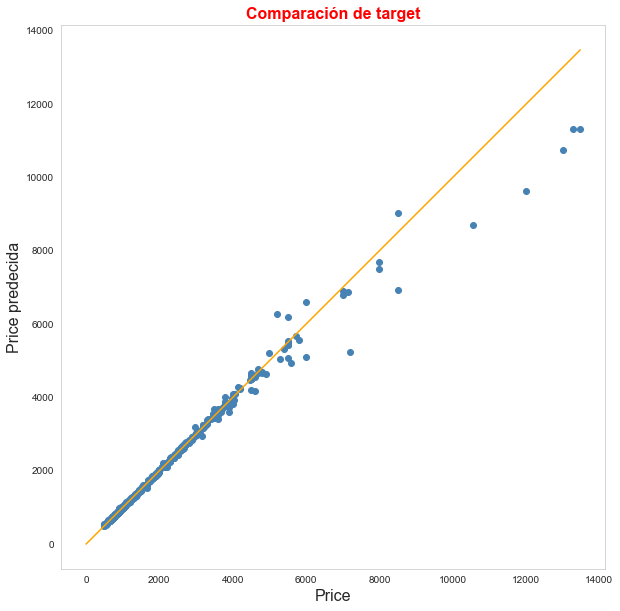

In [225]:
plt.figure(figsize=(10,10))
plt.title(com_target,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Price',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()

Con transformación logarítmica:

In [226]:
%%time
model_pipe = Pipeline([('model', TransformedTargetRegressor(rf,func=np.log,inverse_func=np.exp))])
params_grid_trans={'model__regressor__n_estimators':N}
rf_gscv_trans = GridSearchCV(model_pipe, params_grid_trans, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
rf_gscv_trans.fit(train_x, train_y)

Wall time: 13 s


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=Pipeline(steps=[('model',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=RandomForestRegressor(n_jobs=-1)))]),
             n_jobs=-1,
             param_grid={'model__regressor__n_estimators': array([ 15,  50, 100, 250, 300, 350])},
             scoring='neg_mean_absolute_error')

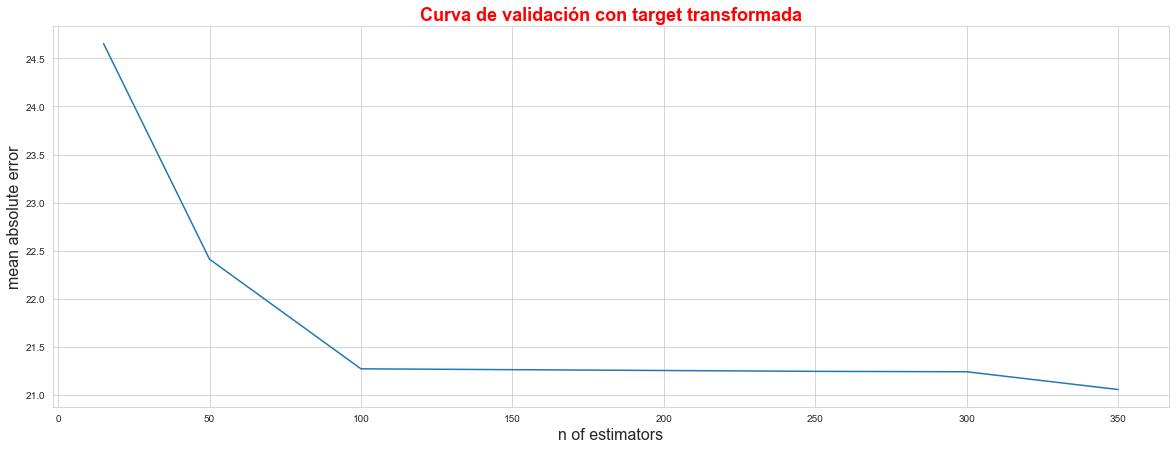

In [227]:
plt.figure(figsize=(20,7))
plt.plot(N, -rf_gscv_trans.cv_results_['mean_test_score']) 
plt.title(curv_val_trans,fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of estimators',fontsize=16)
plt.ylabel('mean absolute error',fontsize=16)
plt.show() 

In [228]:
predict_y=rf_gscv_trans.predict(test_x)
print("Test:",mean_absolute_error(test_y,predict_y).round(2))

Test: 23.83


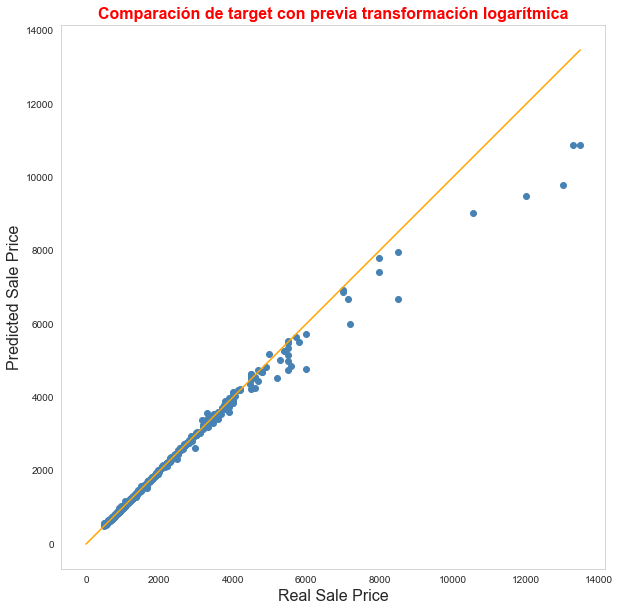

In [229]:
plt.figure(figsize=(10,10))
plt.title(com_target_trans,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

### Gradient Boosting

In [230]:
%%time
N=np.array([15,50,100,300,500,800])
from sklearn.ensemble import GradientBoostingRegressor 
#Creando el modelo
gb = GradientBoostingRegressor()
param_grid = {'n_estimators': N}
#Usando gridsearch para evaluar todos los valores
gb_gscv = GridSearchCV(gb, param_grid, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
#Ajustando el modelo
gb_gscv.fit(train_x, train_y)

Wall time: 10.5 s


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'n_estimators': array([ 15,  50, 100, 300, 500, 800])},
             scoring='neg_mean_absolute_error')

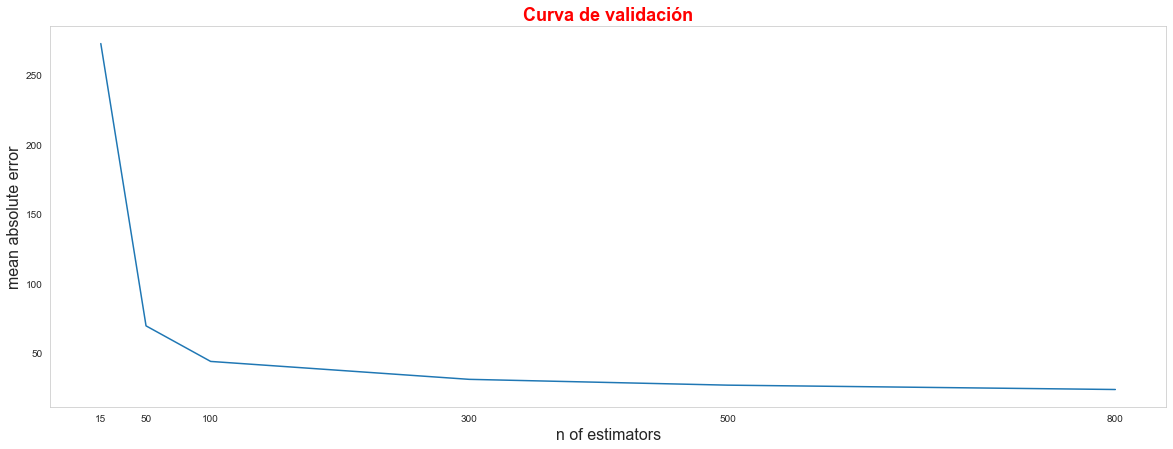

In [231]:
plt.figure(figsize=(20,7))
plt.plot(N, -gb_gscv.cv_results_['mean_test_score']) 
plt.title(curv_val,fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of estimators',fontsize=16)
plt.xticks(N)
plt.ylabel('mean absolute error',fontsize=16)
plt.grid(ls='--',lw=0.7) 
plt.show()   

In [232]:
predict_y=gb_gscv.predict(test_x)
print("Test:",mean_absolute_error(test_y,predict_y).round(2))

Test: 22.48


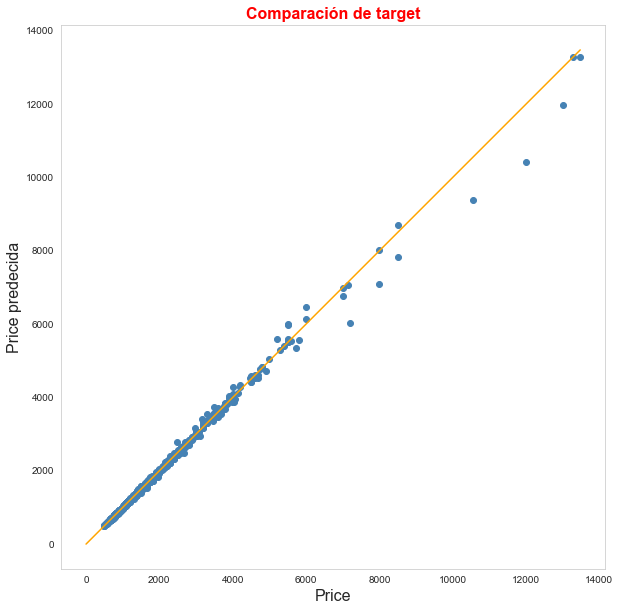

In [233]:
plt.figure(figsize=(10,10))
plt.title(com_target,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Price',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()    

Con tranformación logarítmica:

In [234]:
%%time
model_pipe = Pipeline([('model', TransformedTargetRegressor(gb,func=np.log,inverse_func=np.exp))])
params_grid_trans={'model__regressor__n_estimators':N}
gb_gscv_trans = GridSearchCV(model_pipe, params_grid_trans, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
gb_gscv_trans.fit(train_x, train_y)

Wall time: 10.2 s


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=Pipeline(steps=[('model',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=GradientBoostingRegressor()))]),
             n_jobs=-1,
             param_grid={'model__regressor__n_estimators': array([ 15,  50, 100, 300, 500, 800])},
             scoring='neg_mean_absolute_error')

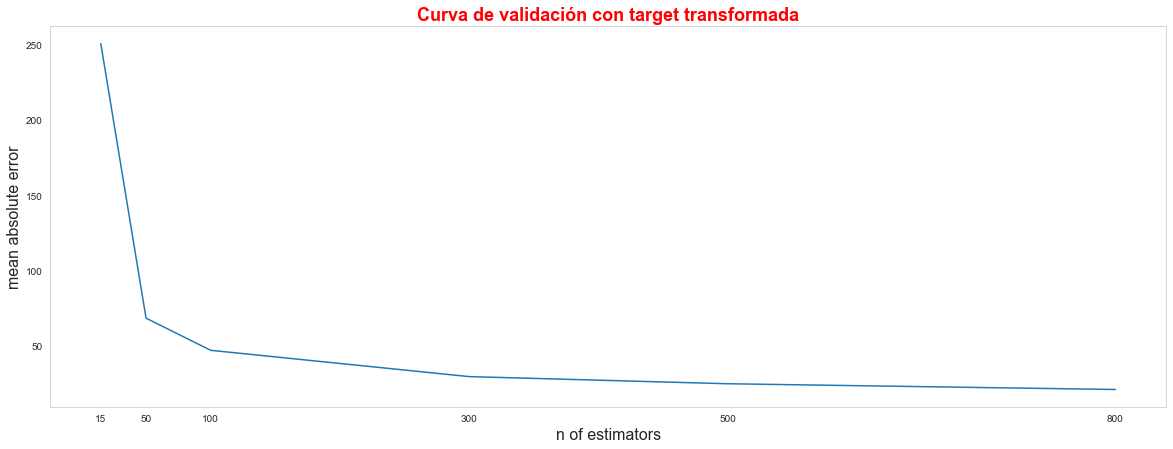

In [235]:
plt.figure(figsize=(20,7))
plt.plot(N, -gb_gscv_trans.cv_results_['mean_test_score']) 
plt.title(curv_val_trans,fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of estimators',fontsize=16)
plt.xticks(N)
plt.ylabel('mean absolute error',fontsize=16)
plt.grid(ls='--',lw=0.7) 
plt.show()    

In [236]:
predict_y=gb_gscv_trans.predict(test_x)
error_gb=mean_absolute_error(test_y,predict_y).round(2)
print("Test:",error_gb)

Test: 20.52


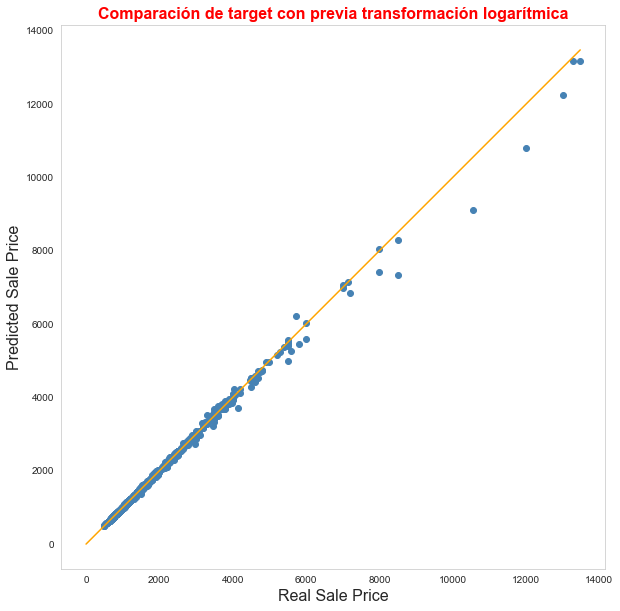

In [237]:
plt.figure(figsize=(10,10))
plt.title(com_target_trans,fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Real Sale Price',fontsize=16)
plt.ylabel('Predicted Sale Price',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

- Es el único método que ofrece una mejor calidad con la transformación logarítmica.
- El único handicap es el tiempo de cálculo para volumenes más grandes.
### Resumen

In [238]:
#Customizando el texto
class color:
   DARKCYAN = '\033[36m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [239]:
metodos=["rl","lasso","elasticnet","knn","rf","gb"]
print(color.DARKCYAN + color.UNDERLINE + color.BOLD+"RESUMEN:" + color.END)
print(color.BOLD + "Métodos".ljust(14),"Error en euros"+ color.END)
for met in metodos:
    print(met.upper().ljust(14),str(eval(f"error_{met}")))

RESUMEN:
Métodos        Error en euros
RL             165.17
LASSO          164.9
ELASTICNET     223.51
KNN            68.63
RF             22.55
GB             20.52
